In [0]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Task 1

In [0]:
with open("reddit.json") as fp:
    data = json.load(fp)
    
# Now the data is loaded.
# It a list of data points, where each datapoint is a dictionary with the following attributes:
# popularity_score : a popularity score for this comment (based on the number of upvotes) (type: float)
# children : the number of replies to this comment (type: int)
# text : the text of this comment (type: string)
# controversiality : a score for how "controversial" this comment is (automatically computed by Reddit)
# is_root : if True, then this comment is a direct reply to a post; if False, this is a direct reply to another comment 

# Example:
data_point = data[0] # select the first data point in the dataset

encoded_data = pd.DataFrame.from_records(data)
encoded_data.iloc[:,2] = np.where(encoded_data['is_root']==True, 1,0)

# Now we print all the information about this datapoint
for info_name, info_value in data_point.items():
    print(info_name + " : " + str(info_value))

text : ITS RAINING SIDEWAYS
is_root : False
controversiality : 0
children : 0
popularity_score : 1.254698160267241


In [0]:
sz_tr=10000; sz_val=1000; sz_test=1000

train = encoded_data[:sz_tr]
val = encoded_data[sz_tr:sz_tr+sz_val]
test = encoded_data[sz_tr+sz_val:]

In [0]:
def tokenize(str):
    '''Tokenize text: Lower case and divide into words.'''
    return str.lower().split(" ")

def build_dictionary(train_data, dict_size=160):
    '''Build dictionary: Find words and count frequency.'''
    # Create an output dictionary to store the word frequencies
    dic = {}
    out = []

    # Loop over each sample of the training set
    for sample in train_data:
        # Split the sample text into lowercase words
        tokens = tokenize(sample['text'])
        # Accumulate words frequencies into the dictionary
        for token in tokens:
            if token in dic:
                dic[token] += 1
            else:
                dic[token] = 1

    # Select the most frequent words only
    i = 0
    for w in sorted(dic, key=dic.get, reverse=True):
        out.append(w)
        if i == dict_size:
            break

    # Return list of most frequent words
    return out

def str2vec(str, dic):
    vec = [0] * len(dic)
    words = tokenize(str)
    for word in words:
      pass
      
# Create dictionary
dic = build_dictionary(train)
print(dic)
print(len(dic))

dic.index("sdibfdbfiud")

TypeError: ignored

In [0]:
train = pd.DataFrame.from_records(train)
train.describe()

,children,controversiality,is_root,popularity_score
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.402400,0.011700,0.420700,0.864073
std,1.341288,0.107537,0.493696,1.168750
min,0.000000,0.000000,0.000000,-6.778971
25%,0.000000,0.000000,0.000000,0.305688
50%,0.000000,0.000000,0.000000,0.612912
75%,1.000000,0.000000,1.000000,1.086221
max,43.000000,1.000000,1.000000,8.373355


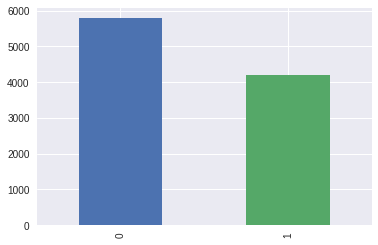

In [0]:
train['is_root'].value_counts().plot.bar()

Most comments have no children. So, it might be a correlation between the number of children and popularity. 

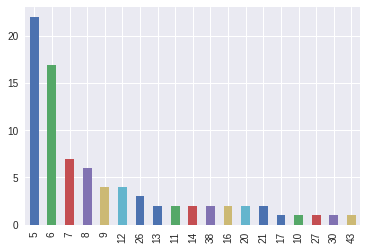

In [0]:
train['children'][train['children']>4].value_counts().plot.bar()

**Yes, there is a correlation.** Most comments with more than 10 replies are quite popular.

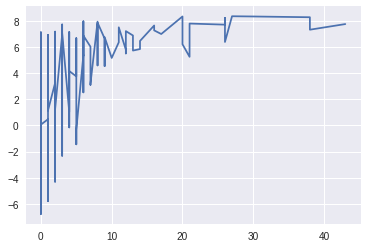

In [0]:
x = train['children']
o = np.argsort(x)
plt.plot(x[o], train['popularity_score'][o], '-')

We are using only 160 words. We are not using many words, so using stop words or some other preprocessig might be crucial. 

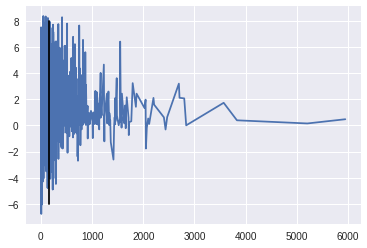

In [0]:
x = train['text'].apply(len)
o = np.argsort(x)
plt.plot(x[o], train['popularity_score'][o], '-')
plt.plot((160, 160), (-6, 8), 'k-')

In [0]:
train.iloc[o.tail(1)].values # Those big comments might be outliers. 

array([[0, 0, False, 0.4784100173851937,
        'Honestly, /u/AndyWinds, when the slaves were brought over here to the USA, they came from many different countries and tribes in Africa. Their cultures were almost as diverse as the cultures that we have now [here]. And the truth is most of our history was \'wiped away\' through slavery. Acting and being anything but "White" was discouraged and many people died from it. They did whatever they had to do to survive so if that meant shaving their hair, making it straight, stopping the spread of their native language(s), bleaching the skin, the list goes on... \n\nHow this is relevant is that at the time is that to differentiate between the "darks" and "lights," Black people were called, well, Black. And White people were called- you get my drift. This is only in the United States of America. [Black](https://en.wikipedia.org/wiki/Black_people) itself has different connotations all across the world so you will get different responses when yo

# Task 2

In [0]:
class LearningRate():
    """Decreases the gradient by fixed learning rate."""
    def __init__(self, lr=10e-6):
        self.lr = lr

    def compute(self, dw):
        return self.lr * dw


class Decay(LearningRate):
    """Decreaces the gradient each iteration at a decay rate."""
    def __init__(self, lr=10e-3, b=10e-4):
        super().__init__(lr)
        self.b = b
        self.decay_step = 1

    def compute(self, dw):
        decay = self.lr / (1 + self.b * self.decay_step)
        self.decay_step += 1
        return decay * dw


class Momentum(LearningRate):
    """GD with momentum. In this case, the grad gives information about the 
    acceleration and the momentum gives the velocity."""
    def __init__(self, lr=10e-3, b=0.9):
        super().__init__(lr)
        self.b = b
        self.momentum = 0

    def compute(self, dw):
        self.momentum = (self.momentum + dw) / 2
        grad = self.b * self.momentum + (1 - self.b) * dw
        return self.lr * grad

In [0]:
class LinearClassifier():
    """ Base class for linear classifiers. """

    def __init__(self, lr=None):
        self.w = None
        self.lr = lr

    def fit(self, X, y):
        """Builds a model given the input data.
        :param X: input data. Values must be numeric.
        :param y: target variable.
        :return:
        """
        raise Exception('I cannot train...')

    def pred(self, X):
        """Predicts values for the input data given.
        :param X: input data.
        """
        X = self.preprocess_input(X)
        return X.dot(self.w)

    def preprocess_input(self, X, y):
        X = X.reshape(X.shape[0], -1)
        bias = np.ones((X.shape[0], 1))
        X = np.hstack((X, bias))

        y = y if len(y.shape) > 1 else y[:, np.newaxis]
        return X, y


class LinearRegressionMSE(LinearClassifier):
    """Linear regression using closed-form solution."""

    def fit(self, X, y):
        X, y = self.preprocess_input(X, y)
        self.w = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
        return self


class LinearRegressionGD(LinearClassifier):
    """Linear regression using gradient descent."""

    def __init__(self, lr):
        super().__init__(lr)
        self.step = 0

    def fit(self, X, y, tol=10e-9):
        X, y = self.preprocess_input(X, y)
        # init value of weights
        w_ = np.random.rand(X.shape[1], 1)
        self.w = np.ones((X.shape[1], 1))
        error = 1

        while (error > tol):
            dw = 2 * (X.T.dot(X).dot(w_) - X.T.dot(y))
            w_ -= self.lr.compute(dw)

            error = np.linalg.norm(np.abs(self.w - w_), 2)
            self.w = w_.copy()
            self.step += 1
        return self

In [0]:
x = np.array([.86, .09, -.85, .87, -.44, -.43, -1.1, .40, -.96, .17])
y = np.array([2.49, .83, -.25, 3.1, .87, .02, -.12, 1.81, -.83, .43])

lse = LinearRegressionMSE()
lse.fit(x, y)
exact = lse.w

In [0]:
lr = [LearningRate(),Decay(),Momentum()]
steps = []
error = []

for lr in lr:
    regressor = LinearRegressionGD(lr)
    regressor.fit(x, y)
    steps.append(regressor.step)
    error.append(np.mean(np.abs(exact - regressor.w)))

In [0]:
lr_lbl = ["Constant", "Decay", "Momentum"]
for i, lbl in enumerate(lr_lbl):
  print("{} (steps={}, error={})".format(lbl, steps[i], error[i]))

Constant (steps=105194, error=6.65509095483241e-05)
Decay (steps=188, error=6.91381863981988e-08)
Momentum (steps=155, error=5.2787293869371865e-08)


# Task 3